In [47]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from io import StringIO
from IPython.display import Image, display
import pydotplus

## Análisis Exploratorio

In [2]:
# Carga de los datos
data = pd.read_excel('Real estate valuation data set.xlsx')
data.head()

No  X1 transaction date  X2 house age  \
0   1          2012.916667          32.0   
1   2          2012.916667          19.5   
2   3          2013.583333          13.3   
3   4          2013.500000          13.3   
4   5          2012.833333           5.0   

   X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                84.87882                               10   
1                               306.59470                                9   
2                               561.98450                                5   
3                               561.98450                                5   
4                               390.56840                                5   

   X5 latitude  X6 longitude  Y house price of unit area  
0     24.98298     121.54024                        37.9  
1     24.98034     121.53951                        42.2  
2     24.98746     121.54391                        47.3  
3     24.98746     121.54391                        54.8  
4     24.97937     121.54245                        43.1

In [3]:
# Información de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [4]:
# Descripción de los datos
data.describe()

No  X1 transaction date  X2 house age  \
count  414.000000           414.000000    414.000000   
mean   207.500000          2013.148953     17.712560   
std    119.655756             0.281995     11.392485   
min      1.000000          2012.666667      0.000000   
25%    104.250000          2012.916667      9.025000   
50%    207.500000          2013.166667     16.100000   
75%    310.750000          2013.416667     28.150000   
max    414.000000          2013.583333     43.800000   

       X3 distance to the nearest MRT station  \
count                              414.000000   
mean                              1083.885689   
std                               1262.109595   
min                                 23.382840   
25%                                289.324800   
50%                                492.231300   
75%                               1454.279000   
max                               6488.021000   

       X4 number of convenience stores  X5 latitude  X6 longitude  \
count                       414.000000   414.000000    414.000000   
mean                          4.094203    24.969030    121.533361   
std                           2.945562     0.012410      0.015347   
min                           0.000000    24.932070    121.473530   
25%                           1.000000    24.963000    121.528085   
50%                           4.000000    24.971100    121.538630   
75%                           6.000000    24.977455    121.543305   
max                          10.000000    25.014590    121.566270   

       Y house price of unit area  
count                  414.000000  
mean                    37.980193  
std                     13.606488  
min                      7.600000  
25%                     27.700000  
50%                     38.450000  
75%                     46.600000  
max                    117.500000

In [5]:
# Elimino la columna 'No'
data.drop('No', axis=1, inplace=True)

# Renombrar columnas
data.columns = ['transaction_date','house_age','distance_to_station','n_stores','latitude','longitude','price']

# Convertir tipo de datos
data['transaction_date'] = pd.to_datetime(data['transaction_date'], format='%Y/%m/%d')

In [6]:
# Observo los valores únicos en la variable 'transaction_date'
data['transaction_date'].unique()

array(['1970-01-01T00:00:00.000002012', '1970-01-01T00:00:00.000002013'],
      dtype='datetime64[ns]')

La variable 'transaction_date' sólo contiene dos elementos distintos que no tienen mayor relevancia para el análisis, por lo que, la elimino de los datos.

In [7]:
data.drop( 'transaction_date', axis=1, inplace=True)

### Visualización de datos geográficos

Contamos con datos geográficos(longitud, latitud). Los visualizamos para buscar patrones.  


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

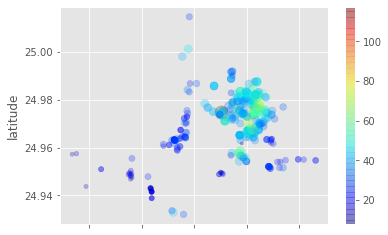

In [8]:
data.plot(kind='scatter', x='longitude', y='latitude', alpha=.25,
          s=data['price']*1.5,c=data['price'], cmap=plt.get_cmap('jet'), colorbar=True)

Podemos observar que existe un área donde se concentran una gran cantidad de viviendas con precios medios-altos, sin embargo, en esta área se puede observar que hay instancias con valores bajos. Las vivivendas de precios más bajos, se encuentran dispersas, por lo general, alejadas del área anteriormente mencionada. 

### Correlaciones

In [9]:
corr_matrix = data.corr(method='spearman')
corr_matrix['price'].sort_values()

distance_to_station   -0.775948
house_age             -0.281753
longitude              0.437672
latitude               0.578419
n_stores               0.617333
price                  1.000000
Name: price, dtype: float64

Mediante el coeficiente de correlación (de Spearman), podemos resaltar que:
* La distancia hasta la estación del metro(distance_to_station) y,
* La cantidad de tiendas de conveniencias cercanas(n_store), 

están fuertemente correlacionadas con el precio de las viviendas. 

## <b>Modelo (Árbol de decisión)

In [10]:
X = data
y = data.pop('price')

In [11]:
# Separar datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=.3)

### DecisionTreeRegressor

Algoritmo de Árbol de decisión (Regresión) con parámetros por defecto.

In [69]:
# Regresor de Bosque Aleatorio
# Entrenamiento del modelo
# =====================================================================
tree_reg = tree.DecisionTreeRegressor(random_state=0)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

### Validación Cruzada (10 k-folds)

Realizo una validación cruzada de 10 k-folds para evaluar la capacidad de predicción del modelo (con los hiperparámetros por defecto).

In [71]:
# Cross-Validation
# =====================================================================
y_preds = cross_val_score(tree_reg, X_train, y_train,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse = np.sqrt(-y_preds)
print('RMSE de los 10 k-folds:')
print(tree_rmse)
print()
rmse_mean = round(np.mean(tree_rmse),2)
rmse_std = round(np.std(tree_rmse),2)
print(f'RMSE promedio: {rmse_mean}, desviación: {rmse_std}')


RMSE de los 10 k-folds:
[ 6.78632344 14.7787683   8.41347897  8.68067667 10.19287746 10.52915902
  8.36983557 11.72224161  5.53721301  9.6357768 ]

RMSE promedio: 9.46, desviación: 2.46


### Ajuste del modelo

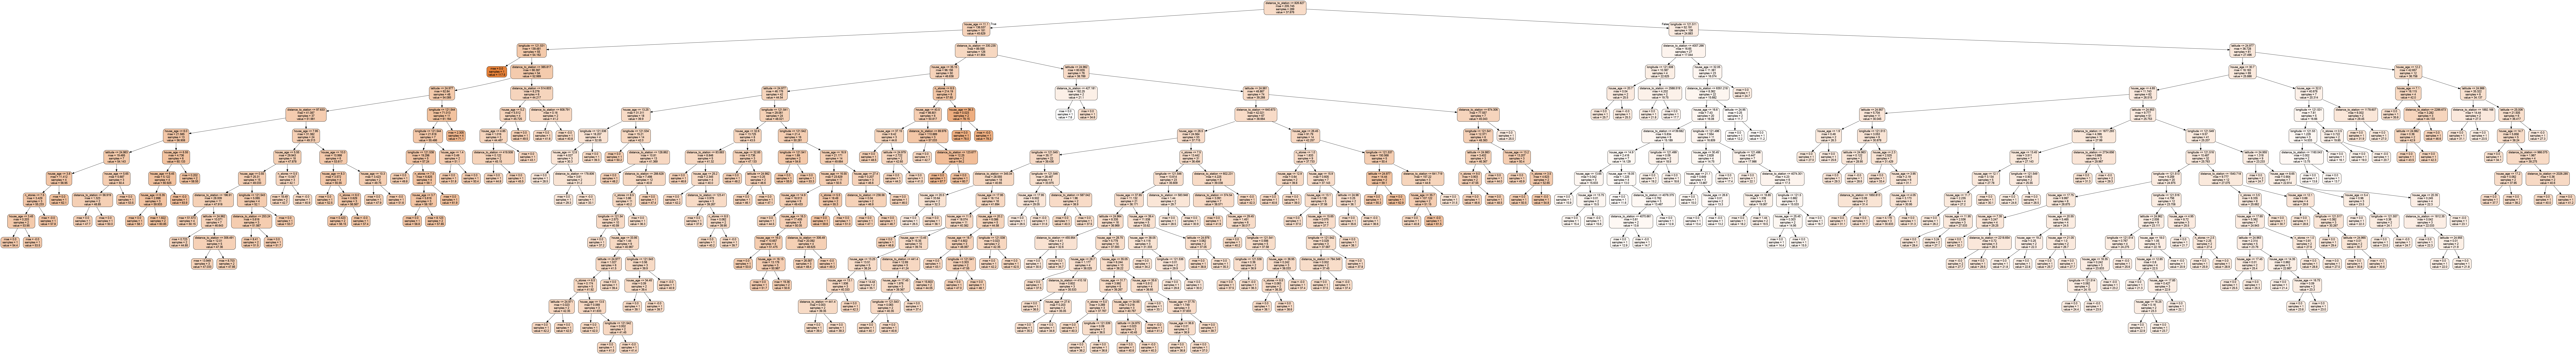

In [72]:
dot_data = StringIO()  
tree.export_graphviz(tree_reg, out_file=dot_data,
                     feature_names=X_train.columns,
                     class_names=y_train.name,
                     rounded=True,
                     filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

In [45]:
importancia_predictores = pd.DataFrame(
                            {'predictor': data.columns,
                             'importancia': tree_reg.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)



Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
1  distance_to_station     0.701187
4            longitude     0.141934
0            house_age     0.129645
3             latitude     0.027233
2             n_stores     0.000000

In [50]:
len(y_train)

289